In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
from spiketimes.df.surrogates import shuffled_isi_spiketrains_by
from spiketimes.df.statistics import ifr_by
from onep.stats import p_adjust
from onep.utils import create_combined_col
from scipy import stats
from citalopram_project.load import load_spikes, load_neurons
from citalopram_project.correlations import shuffled_isi_correlation_test, get_combs
from tqdm.notebook import tqdm

In [2]:
neurons = load_neurons()
spikes = load_spikes(block_name="base_shock").merge(neurons[["neuron_id", "session_name", "cluster"]])

In [3]:
baseline_spikes = spikes.loc[lambda x: x.spiketimes < 0].copy()
baseline_spikes.loc[:, "spiketimes"] = baseline_spikes.loc[:, "spiketimes"].add(600)
shock_spikes = spikes.loc[lambda x: x.spiketimes >= 0]

In [4]:
session_names = neurons.session_name.unique()
baseline_frames = []
for session in tqdm(session_names):
    df1 = baseline_spikes.loc[lambda x: x.session_name == session]
    if len(df1) == 0:
        continue
    res = shuffled_isi_correlation_test(df1, bin_width=1, n_boot=1000)
    baseline_frames.append(res.assign(session_name=session))

  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
df_base = pd.concat(baseline_frames)
df_base["block"] = "baseline"
df_base = get_combs(df_base, load_neurons()[["neuron_id", "cluster"]])
df_base = df_base.merge(load_neurons()[["session_name", "group"]].drop_duplicates())

df_base.to_csv(r"C:\Users\roryl\repos\citalopram-project\data\derived\baseline_baseshock_rsc.csv")
# df_base

In [7]:
shock_frames = []
for session in tqdm(session_names):
    df1 = shock_spikes.loc[lambda x: x.session_name == session]
    if len(df1) == 0:
        continue
    res = shuffled_isi_correlation_test(df1, bin_width=1, n_boot=1000)
    shock_frames.append(res.assign(session_name=session))

  0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
df_shock = pd.concat(shock_frames)
df_shock["block"] = "base_shock"
df_shock = get_combs(df_shock, load_neurons()[["neuron_id", "cluster"]])
df_shock = df_shock.merge(load_neurons()[["session_name", "group"]].drop_duplicates())

df_shock.to_csv(r"C:\Users\roryl\repos\citalopram-project\data\derived\baseshock_rsc.csv")


In [12]:
pd.concat([df_base, df_shock]).to_csv(r"C:\Users\roryl\repos\citalopram-project\data\derived\rsc_footshock_comboned.csv")

In [13]:
df_all = pd.concat([df_base, df_shock])

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     117.7
Date:                Sun, 09 Jan 2022   Prob (F-statistic):           4.57e-75
Time:                        11:27:55   Log-Likelihood:                 1356.2
No. Observations:               11269   AIC:                            -2704.
Df Residuals:                   11265   BIC:                            -2675.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

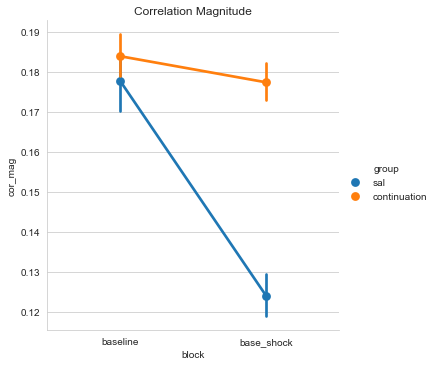

<Figure size 432x288 with 0 Axes>

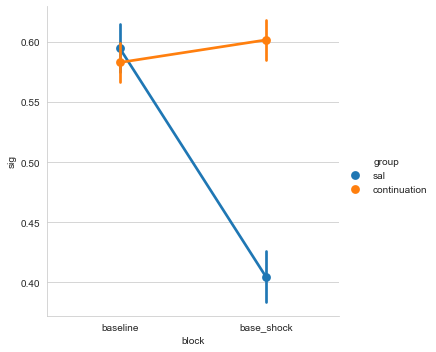

<Figure size 432x288 with 0 Axes>

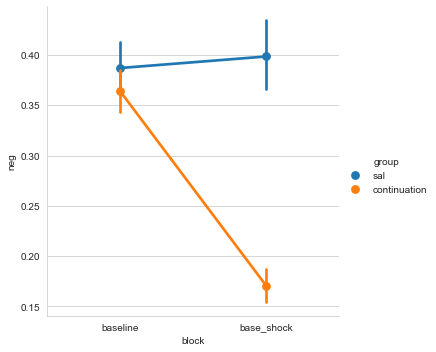

In [44]:
import statsmodels.formula.api as smf

sns.set_style("whitegrid")
df_all[["neuron_combination", "value", "p_adj", "block", "group"]]
df_all["cor_mag"] = df_all["value"].abs()
df_all["block"] = pd.Categorical(df_all["block"], categories=("baseline", "base_shock"), ordered=True)

# md = smf.mixedlm("value ~ block * group", df_all, groups=df_all["neuron_combination"])
md = smf.ols("value ~ block * group", df_all)
mod_res = md.fit()
print(mod_res.summary())

plt.figure()
sns.catplot(x="block", y="cor_mag", hue="group", data=df_all, kind="point", position="dodge")
plt.title("Correlation Magnitude")
plt.savefig("all neurons - corr mag change.svg")


plt.figure()
sns.catplot(x="block", y="sig", hue="group", data=df_all, kind="point")
mod1 = smf.glm(formula="sig ~ block * group", data=df_all, family=sm.families.Binomial()).fit()
print(mod1.summary())
plt.savefig("all neurons - sig change.svg")

plt.figure()
sns.catplot(x="block", y="neg", hue="group", data=df_all.loc[lambda x: x.sig], kind="point")
mod1 = smf.glm(formula="neg ~ block * group", data=df_all.loc[lambda x: x.sig], family=sm.families.Binomial()).fit()
print(mod1.summary())
plt.savefig("all neurons - neg change.svg")


                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     24.64
Date:                Sun, 09 Jan 2022   Prob (F-statistic):           1.02e-15
Time:                        12:12:40   Log-Likelihood:                 93.469
No. Observations:                2595   AIC:                            -178.9
Df Residuals:                    2591   BIC:                            -155.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

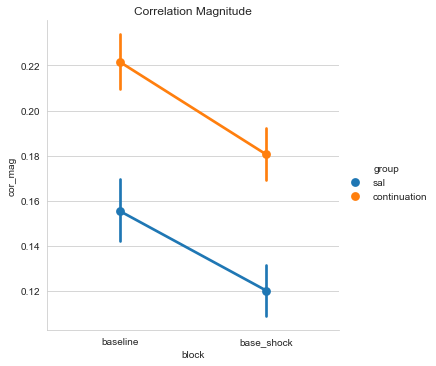

<Figure size 432x288 with 0 Axes>

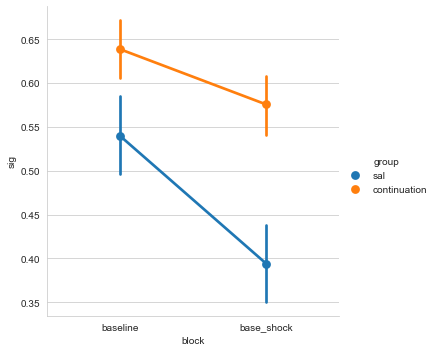

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['neg[False]', 'neg[True]']   No. Observations:                 1442
Model:                                     GLM   Df Residuals:                     1438
Model Family:                         Binomial   Df Model:                            3
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -904.20
Date:                         Sun, 09 Jan 2022   Deviance:                       1808.4
Time:                                 12:12:42   Pearson chi2:                 1.44e+03
No. Iterations:                              4                                         
Covariance Type:                     nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.1765      0.127      1.390      0.165      -0.072       0.425
block[T.base_shock]                           0.0349      0.193      0.180      0.857      -0.344       0.414
group[T.continuation]                         0.3071      0.155      1.976      0.048       0.002       0.612
block[T.base_shock]:group[T.continuation]     0.7411      0.240      3.086      0.002       0.270       1.212
=============================================================================================================
"""

<Figure size 432x288 with 0 Axes>

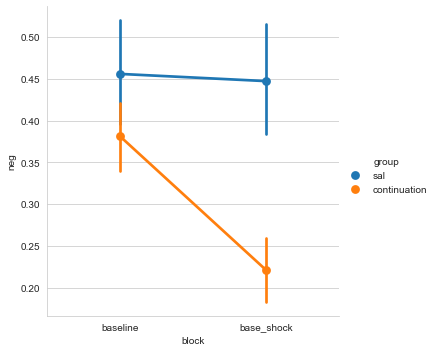

In [45]:
import statsmodels.formula.api as smf

DF = df_all.loc[lambda x: x.comb == "slow_regular-slow_regular"]

# md = smf.mixedlm("value ~ block * group", df_all, groups=df_all["neuron_combination"])
md = smf.ols("value ~ block * group", DF)
mod_res = md.fit()
print(mod_res.summary())

plt.figure()
sns.catplot(x="block", y="cor_mag", hue="group", data=DF, kind="point", position="dodge")
plt.title("Correlation Magnitude")


plt.figure()
sns.catplot(x="block", y="sig", hue="group", data=DF, kind="point")
mod1 = smf.glm(formula="sig ~ block * group", data=DF, family=sm.families.Binomial()).fit()
print(mod1.summary())
plt.show()


plt.figure()
sns.catplot(x="block", y="neg", hue="group", data=DF.loc[lambda x: x.sig], kind="point")
mod1 = smf.glm(formula="neg ~ block * group", data=DF.loc[lambda x: x.sig], family=sm.families.Binomial()).fit()
mod1.summary()

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     59.96
Date:                Sun, 09 Jan 2022   Prob (F-statistic):           4.23e-38
Time:                        12:12:42   Log-Likelihood:                 794.32
No. Observations:                5173   AIC:                            -1581.
Df Residuals:                    5169   BIC:                            -1554.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

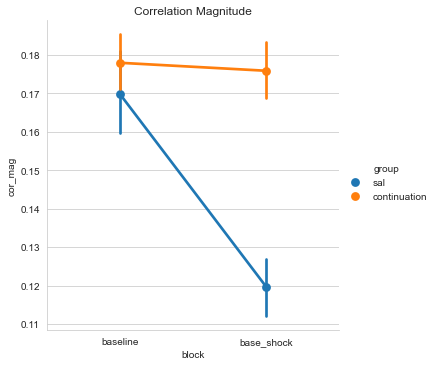

<Figure size 432x288 with 0 Axes>

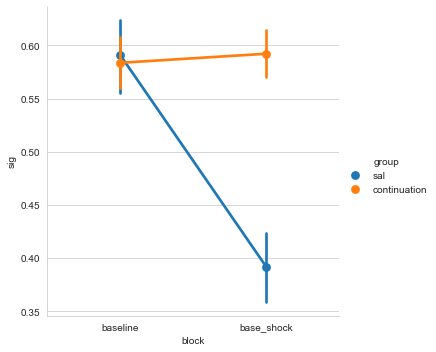

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['neg[False]', 'neg[True]']   No. Observations:                 2878
Model:                                     GLM   Df Residuals:                     2874
Model Family:                         Binomial   Df Model:                            3
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -1691.5
Date:                         Sun, 09 Jan 2022   Deviance:                       3383.0
Time:                                 12:12:44   Pearson chi2:                 2.88e+03
No. Iterations:                              4                                         
Covariance Type:                     nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.4107      0.093      4.401      0.000       0.228       0.594
block[T.base_shock]                           0.0174      0.146      0.119      0.905      -0.269       0.304
group[T.continuation]                         0.1283      0.114      1.130      0.259      -0.094       0.351
block[T.base_shock]:group[T.continuation]     1.0427      0.180      5.795      0.000       0.690       1.395
=============================================================================================================
"""

<Figure size 432x288 with 0 Axes>

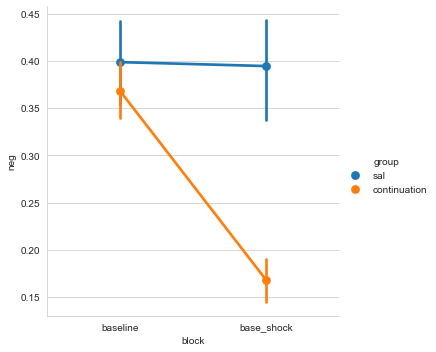

In [46]:
import statsmodels.formula.api as smf

DF = df_all.loc[lambda x: x.comb == "slow_irregular-slow_regular"]

# md = smf.mixedlm("value ~ block * group", df_all, groups=df_all["neuron_combination"])
md = smf.ols("value ~ block * group", DF)
mod_res = md.fit()
print(mod_res.summary())

plt.figure()
sns.catplot(x="block", y="cor_mag", hue="group", data=DF, kind="point", position="dodge")
plt.title("Correlation Magnitude")


plt.figure()
sns.catplot(x="block", y="sig", hue="group", data=DF, kind="point")
mod1 = smf.glm(formula="sig ~ block * group", data=DF, family=sm.families.Binomial()).fit()
print(mod1.summary())
plt.show()


plt.figure()
sns.catplot(x="block", y="neg", hue="group", data=DF.loc[lambda x: x.sig], kind="point")
mod1 = smf.glm(formula="neg ~ block * group", data=DF.loc[lambda x: x.sig], family=sm.families.Binomial()).fit()
mod1.summary()

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7711
Date:                Sun, 09 Jan 2022   Prob (F-statistic):              0.511
Time:                        12:13:26   Log-Likelihood:                -45.621
No. Observations:                 451   AIC:                             99.24
Df Residuals:                     447   BIC:                             115.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

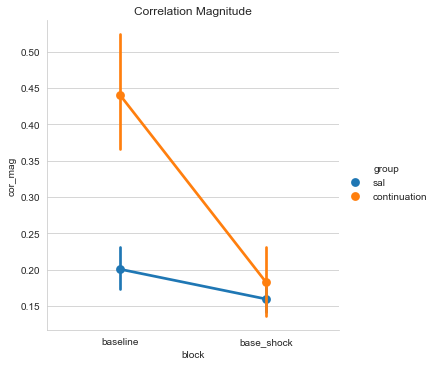

<Figure size 432x288 with 0 Axes>

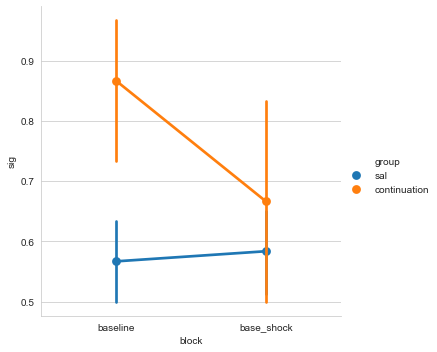

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['neg[False]', 'neg[True]']   No. Observations:                  271
Model:                                     GLM   Df Residuals:                      267
Model Family:                         Binomial   Df Model:                            3
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -187.07
Date:                         Sun, 09 Jan 2022   Deviance:                       374.15
Time:                                 12:13:27   Pearson chi2:                     271.
No. Iterations:                              4                                         
Covariance Type:                     nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -0.0364      0.191     -0.191      0.849      -0.410       0.337
block[T.base_shock]                           0.0886      0.267      0.332      0.740      -0.434       0.611
group[T.continuation]                         0.3465      0.440      0.787      0.431      -0.517       1.210
block[T.base_shock]:group[T.continuation]     0.0068      0.661      0.010      0.992      -1.289       1.303
=============================================================================================================
"""

<Figure size 432x288 with 0 Axes>

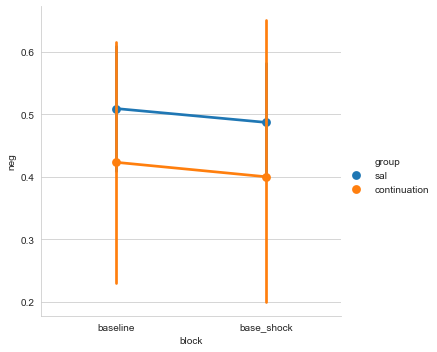

In [48]:
import statsmodels.formula.api as smf

DF = df_all.loc[lambda x: x.comb == "slow_regular-fast_firing"]

# md = smf.mixedlm("value ~ block * group", df_all, groups=df_all["neuron_combination"])
md = smf.ols("value ~ block * group", DF)
mod_res = md.fit()
print(mod_res.summary())

plt.figure()
sns.catplot(x="block", y="cor_mag", hue="group", data=DF, kind="point", position="dodge")
plt.title("Correlation Magnitude")


plt.figure()
sns.catplot(x="block", y="sig", hue="group", data=DF, kind="point")
mod1 = smf.glm(formula="sig ~ block * group", data=DF, family=sm.families.Binomial()).fit()
print(mod1.summary())
plt.show()


plt.figure()
sns.catplot(x="block", y="neg", hue="group", data=DF.loc[lambda x: x.sig], kind="point")
mod1 = smf.glm(formula="neg ~ block * group", data=DF.loc[lambda x: x.sig], family=sm.families.Binomial()).fit()
mod1.summary()

In [18]:
df_all_srsr = df_all.loc[lambda x: x.comb == "slow_regular-fast_firing"]

md = smf.mixedlm("cor_mag ~ block * group", df_all_srsr, groups=df_all_srsr["neuron_combination"])
mod_res = md.fit()
print(mod_res.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          cor_mag 
No. Observations:          451              Method:                      REML    
No. Groups:                227              Scale:                       0.0234  
Min. group size:           1                Log-Likelihood:              152.9838
Max. group size:           2                Converged:                   Yes     
Mean group size:           2.0                                                   
---------------------------------------------------------------------------------
                                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.160    0.012 13.173 0.000  0.136  0.183
block[T.baseline]                       0.041    0.015  2.654 0.008  0.011  0.071
group[T.continuation]                 

C:\Users\roryl\.conda\envs\ephys\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


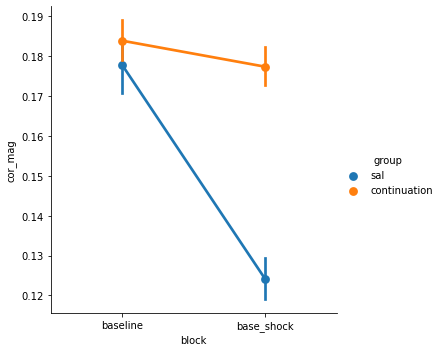

In [29]:
import seaborn as sns
sns.catplot(x="block", y="cor_mag", hue="group", data=df_all, kind="point")
# df_all

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['sig[False]', 'sig[True]']   No. Observations:                11269
Model:                                     GLM   Df Residuals:                    11265
Model Family:                         Binomial   Df Model:                            3
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -7612.0
Date:                         Sun, 09 Jan 2022   Deviance:                       15224.
Time:                                 11:03:17   Pearson chi2:                 1.13e+04
No. Iterations:                              4                                         
Covariance Type:                     nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.3868      0.044      8.784      0.000       0.301       0.473
block[T.baseline]                          -0.7699      0.063    -12.279      0.000      -0.893      -0.647
group[T.continuation]                      -0.7996      0.056    -14.307      0.000      -0.909      -0.690
block[T.baseline]:group[T.continuation]     0.8475      0.079     10.692      0.000       0.692       1.003
===========================================================================================================
"""

<Figure size 432x288 with 0 Axes>

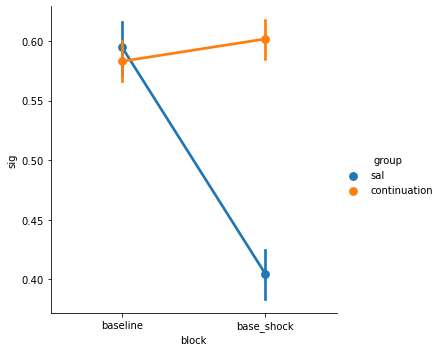

In [20]:
df_all["sig"] = df_all["p_adj"] < 0.05
import statsmodels.api as sm
import matplotlib.pyplot as plt 


plt.figure()
sns.catplot(x="block", y="sig", hue="group", data=df_all, kind="point")

mod1 = smf.glm(formula="sig ~ block * group", data=df_all, family=sm.families.Binomial()).fit()
mod1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['neg[False]', 'neg[True]']   No. Observations:                 6278
Model:                                     GLM   Df Residuals:                     6274
Model Family:                         Binomial   Df Model:                            3
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -3724.4
Date:                         Sun, 09 Jan 2022   Deviance:                       7448.8
Time:                                 11:03:18   Pearson chi2:                 6.28e+03
No. Iterations:                              4                                         
Covariance Type:                     nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.4122      0.069      5.939      0.000       0.276       0.548
block[T.baseline]                           0.0481      0.091      0.530      0.596      -0.130       0.226
group[T.continuation]                       1.1681      0.090     12.939      0.000       0.991       1.345
block[T.baseline]:group[T.continuation]    -1.0711      0.117     -9.165      0.000      -1.300      -0.842
===========================================================================================================
"""

<Figure size 432x288 with 0 Axes>

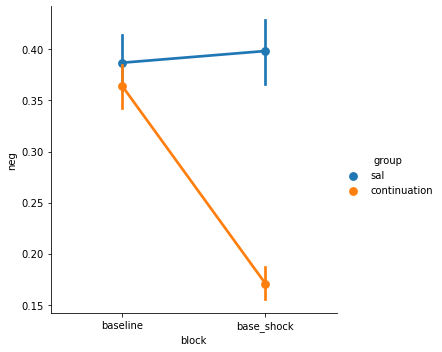

In [21]:
df_all["neg"] = df_all["value"] < 0
import statsmodels.api as sm
import matplotlib.pyplot as plt 


plt.figure()
sns.catplot(x="block", y="neg", hue="group", data=df_all.loc[lambda x: x.sig], kind="point")

mod1 = smf.glm(formula="neg ~ block * group", data=df_all.loc[lambda x: x.sig], family=sm.families.Binomial()).fit()
mod1.summary()

In [104]:
(df_all["value"] < 0).sum()

0

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['sig[False]', 'sig[True]']   No. Observations:                 2595
Model:                                     GLM   Df Residuals:                     2591
Model Family:                         Binomial   Df Model:                            3
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -1744.7
Date:                         Sun, 09 Jan 2022   Deviance:                       3489.3
Time:                                 11:05:37   Pearson chi2:                 2.59e+03
No. Iterations:                              4                                         
Covariance Type:                     nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.4297      0.093      4.610      0.000       0.247       0.612
block[T.baseline]                          -0.5899      0.132     -4.474      0.000      -0.848      -0.331
group[T.continuation]                      -0.7351      0.117     -6.292      0.000      -0.964      -0.506
block[T.baseline]:group[T.continuation]     0.3252      0.166      1.957      0.050      -0.000       0.651
===========================================================================================================
"""

<Figure size 432x288 with 0 Axes>

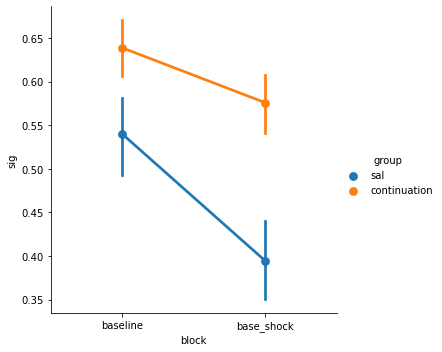

In [25]:
df_all_srsr = df_all.loc[lambda x: x.comb == "slow_regular-slow_regular"]

plt.figure()
sns.catplot(x="block", y="sig", hue="group", data=df_all_srsr, kind="point")

mod1 = smf.glm(formula="sig ~ block * group", data=df_all_srsr, family=sm.families.Binomial()).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['sig[False]', 'sig[True]']   No. Observations:                 5173
Model:                                     GLM   Df Residuals:                     5169
Model Family:                         Binomial   Df Model:                            3
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -3497.4
Date:                         Sun, 09 Jan 2022   Deviance:                       6994.8
Time:                                 11:05:56   Pearson chi2:                 5.17e+03
No. Iterations:                              4                                         
Covariance Type:                     nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.4390      0.070      6.238      0.000       0.301       0.577
block[T.baseline]                          -0.8086      0.100     -8.061      0.000      -1.005      -0.612
group[T.continuation]                      -0.8119      0.085     -9.497      0.000      -0.979      -0.644
block[T.baseline]:group[T.continuation]     0.8438      0.121      6.946      0.000       0.606       1.082
===========================================================================================================
"""

<Figure size 432x288 with 0 Axes>

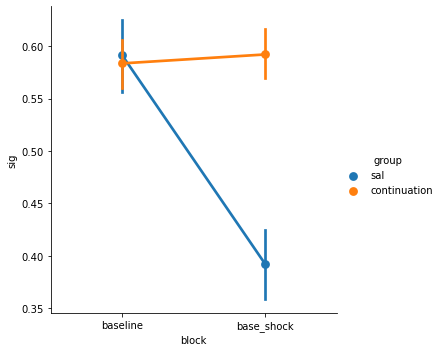

In [26]:
df_all_srsr = df_all.loc[lambda x: x.comb == "slow_irregular-slow_regular"]

plt.figure()
sns.catplot(x="block", y="sig", hue="group", data=df_all_srsr, kind="point")

mod1 = smf.glm(formula="sig ~ block * group", data=df_all_srsr, family=sm.families.Binomial()).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['sig[False]', 'sig[True]']   No. Observations:                  451
Model:                                     GLM   Df Residuals:                      447
Model Family:                         Binomial   Df Model:                            3
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -297.37
Date:                         Sun, 09 Jan 2022   Deviance:                       594.74
Time:                                 11:06:18   Pearson chi2:                     451.
No. Iterations:                              4                                         
Covariance Type:                     nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -0.3382      0.145     -2.340      0.019      -0.621      -0.055
block[T.baseline]                           0.0685      0.205      0.335      0.738      -0.333       0.470
group[T.continuation]                      -0.3549      0.413     -0.859      0.391      -1.165       0.455
block[T.baseline]:group[T.continuation]    -1.2472      0.693     -1.800      0.072      -2.606       0.111
===========================================================================================================
"""

<Figure size 432x288 with 0 Axes>

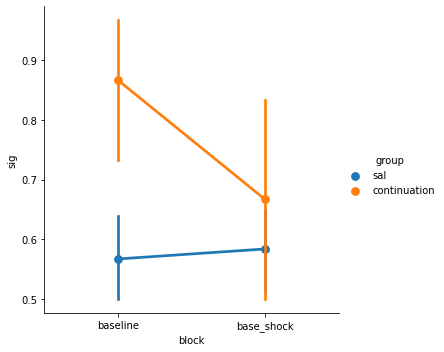

In [27]:
df_all_srsr = df_all.loc[lambda x: x.comb == "slow_regular-fast_firing"]

plt.figure()
sns.catplot(x="block", y="sig", hue="group", data=df_all_srsr, kind="point")

mod1 = smf.glm(formula="sig ~ block * group", data=df_all_srsr, family=sm.families.Binomial()).fit()
mod1.summary()

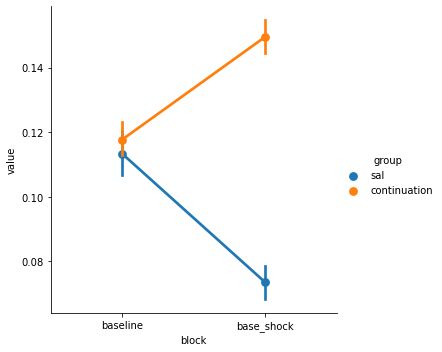

In [89]:
sns.catplot(x="block", y="value", hue="group", data=df_all, kind="point")

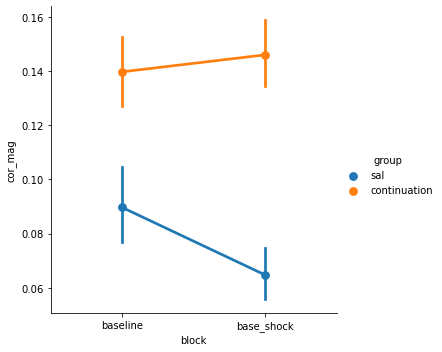

In [90]:
sns.catplot(x="block", y="cor_mag", hue="group", data=df_all.loc[lambda x: x.comb == "slow_regular-slow_regular"], kind="point")


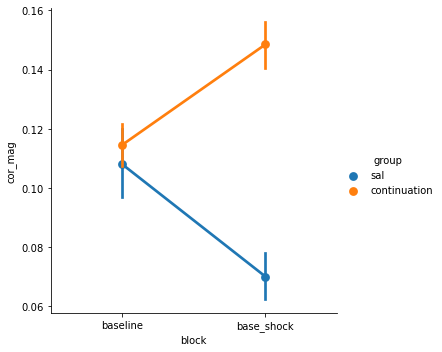

In [91]:
sns.catplot(x="block", y="cor_mag", hue="group", data=df_all.loc[lambda x: x.comb == "slow_irregular-slow_regular"], kind="point")


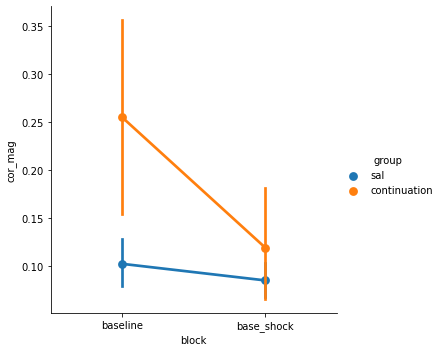

In [92]:
sns.catplot(x="block", y="cor_mag", hue="group", data=df_all.loc[lambda x: x.comb == "slow_regular-fast_firing"], kind="point")


In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

def compare_pct(df):
    out = {}
    sal = df.loc[lambda x: x.group == "sal"]
    cit = df.loc[lambda x: x.group == "continuation"]
    out["n_sal"] = len(sal)
    out["n_cit"] = len(cit)
    out["prop_sal"] = sal.sig.mean()
    out["prop_cit"] = cit.sig.mean()
    z, p = proportions_ztest([sal.sig.sum(), cit.sig.sum()], [len(sal), len(cit)])
    out["statistic"] = z
    out["pval"] = p
    return pd.Series(out)


def compare_neg(df):
    out = {}
    sal = df.loc[lambda x: (x.group == "sal") & (x.sig)]
    cit = df.loc[lambda x: (x.group == "continuation") & (x.sig)]
    out["n_sal"] = len(sal)
    out["n_cit"] = len(cit)
    out["prop_sal"] = (sal.statistic < 0).mean()
    out["prop_cit"] = (cit.statistic < 0).mean()
    z, p = proportions_ztest([(sal.statistic < 0).sum(), (cit.statistic < 0).sum()], [len(sal), len(cit)])
    out["statistic"] = z
    out["pval"] = p
    return pd.Series(out)


def compare_mag(df):
    out = {}
    sal = df.loc[lambda x: (x.group == "sal")]
    cit = df.loc[lambda x: (x.group == "continuation")]
    out["n_sal"] = len(sal)
    out["n_cit"] = len(cit)
    x = sal.statistic.abs()
    y = cit.statistic.abs()
    u, p = mannwhitneyu(x, y)
    out["statistic"] = u
    out["pval"] = p
    return pd.Series(out)